# CNN Dog Breed Classication

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. This dataset is being imported from the official page from Stanford

The contents of the dataset are:

 - **Number of categories**: 120
 - **Number of images**: 20,580
 - **Image Dimensions**: (256,256)

Since there are only about 170 images per category. It would be beneficial to use transfer learning.
We will be using the pre-trained model Inception V3 which has been trained on 'imagenet'. The weights will be freezed, and then we will create new layers to get the desired output

## Libraries and Config

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [35]:
tf.__version__

'2.16.1'

In [36]:
IMAGE_SIZE = 256
BATCH_SIZE = 256
CHANNELS = 3

## Transfer Learning


Inception v3 is a highly efficient convolutional neural network renowned for its depth and exceptional performance in image classification tasks. Its innovative design incorporates factorized convolutions and regularization techniques, making it well-suited for transfer learning. Leveraging pre-trained weights from datasets like ImageNet, Inception v3 enables effective fine-tuning on domain-specific data, playing a pivotal role in various computer vision applications.

In [37]:
# Load the InceptionV3 model
inception = tf.keras.applications.InceptionV3(
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    include_top=False, 
    weights='imagenet')
# Freeze the pre-trained model weights
inception.trainable = False

Get the class names from a breed txt file in the same order of the one hot encoding 

In [38]:
def class_names_txt(filepath):
    """
    Read a text file and save each line as an element in a list.
    """
    names = []
    with open(filepath, 'r') as file:
        for line in file:
            # Remove newline characters and any trailing/leading whitespaces
            cleaned_line = line.strip()
            cleaned_line = cleaned_line.replace("'", "")
            cleaned_line = cleaned_line.replace(",", "")
            names.append(cleaned_line)
    return names

filepath = "Dataset/breeds.txt"  
class_names = class_names_txt(filepath)

## Data Augmentation

Now we set up the image data augmentation and generators for training and validation in a convolutional neural network (CNN) model using TensorFlow and Keras. It rescales, rotates, zooms, and flips images for augmentation. Then, it generates batches of training and validation images from a specified directory, resizing them to a target size and categorizing them based on class mode. Finally, it prints the sizes of the training and validation datasets to confirm the number of images available for model training and evaluation.

In [39]:
# Dir with the dataset
train_data_dir = './Dataset/Images/'
# Data augmentation
train_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
                                   rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range = 15,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)

# Flow training images in batches of 256 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') 

# Flow validation images in batches of 256 using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, #mini-batches of size 512 images
    class_mode='categorical',
    subset='validation')

# Number of images in the training and validation sets
TRAIN_SIZE = train_generator.samples
VALIDATION_SIZE = validation_generator.samples
print("Train size: ", TRAIN_SIZE)
print("Validation size: ", VALIDATION_SIZE)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Train size:  16508
Validation size:  4072


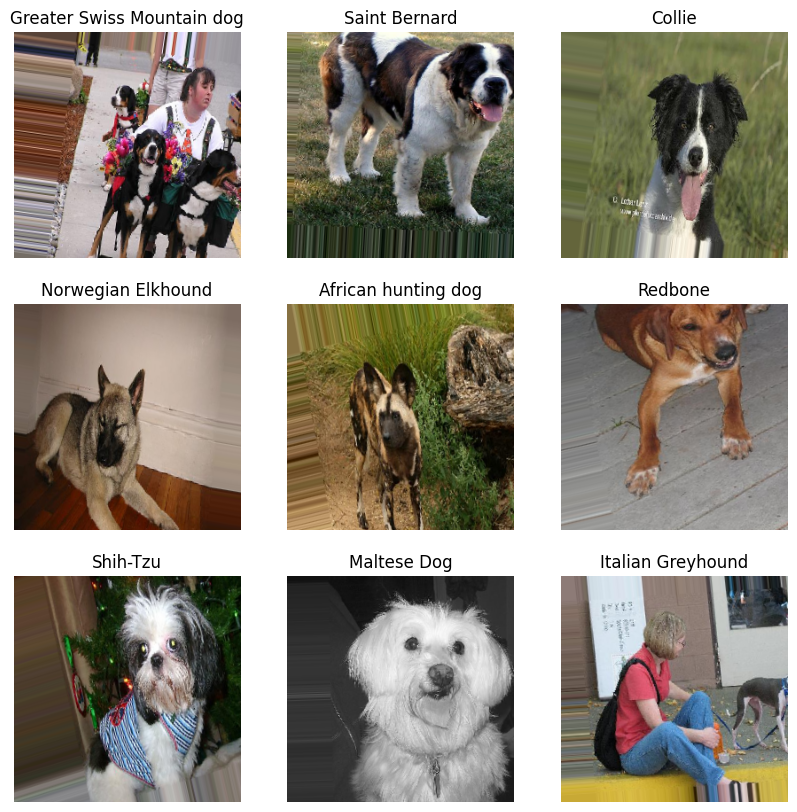

In [40]:
# Create plot to show some images
plt.figure(figsize=(10, 15))
# Get the first batch of images from the generator
images, labels = next(train_generator)
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

## Model

In [41]:
# Create the model
model = tf.keras.Sequential([
                             inception, #inception layer
                             tf.keras.layers.GlobalAveragePooling2D(), #GlobalAveragePooling2D layer
                             tf.keras.layers.Flatten(), # Flatten layer
                             tf.keras.layers.Dropout(rate=0.2), #Dropout layer
                             tf.keras.layers.Dense(240,activation='relu'), # Dense layer
                             tf.keras.layers.Dropout(rate=0.1), #Dropout layer
                             tf.keras.layers.Dense(240,activation = 'relu'), # Dense layer
                             tf.keras.layers.Dropout(rate=0), #Dropout layer
                             tf.keras.layers.Dense(120,activation = 'softmax') # Output layer
                             
])

In [42]:
# Optimizer and loss function
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.99)
# Compile the model
model.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
# Define the number of epochs
EPOCHS = 20
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = int(TRAIN_SIZE/BATCH_SIZE),
    validation_data = validation_generator, 
    validation_steps = int(VALIDATION_SIZE/BATCH_SIZE),
    epochs = EPOCHS)

## Model Results

In [45]:
# Get the keys of the history object
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [46]:
# Get the accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Get the loss and val_loss
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

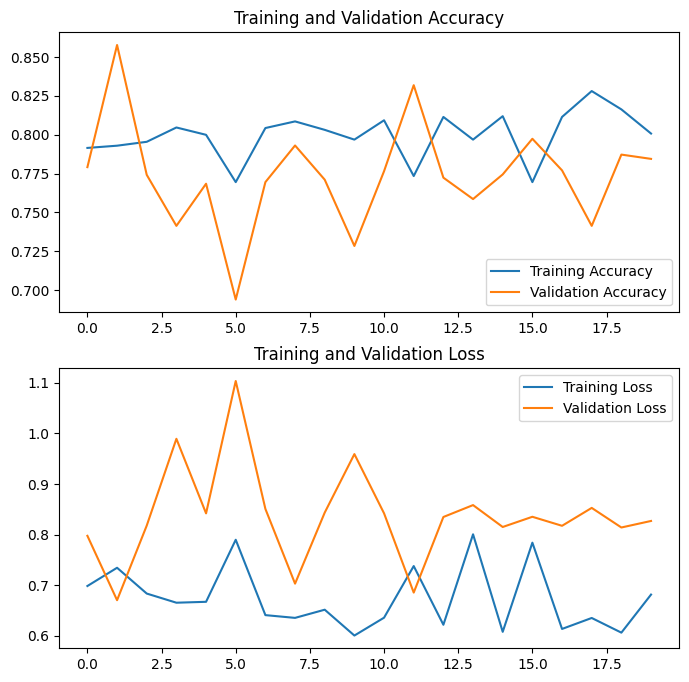

In [47]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(8, 8))
# Accuracy
plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
# Loss
plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# Add labels
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step


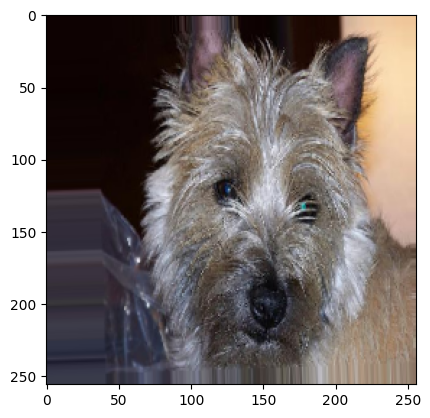

Predicted label:  Cairn Terrier
Actual label:  Cairn Terrier


In [70]:
# Get the first batch of images from the generator
images_val, labels_val = next(validation_generator)
# Predict the labels of the images
labels_predict = model.predict(images_val)
# Generate a random number
random_int = np.random.randint(0, BATCH_SIZE)
# Get the predicted and actual label
predicted_label = class_names[np.argmax(labels_predict[random_int])]
actual_label = class_names[np.argmax(labels_val[random_int])]
# Plot the image
plt.imshow(images_val[random_int])
plt.show()
# Print the predicted and actual label
print("Predicted label: ", predicted_label)
print("Actual label: ", actual_label)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 710ms/step


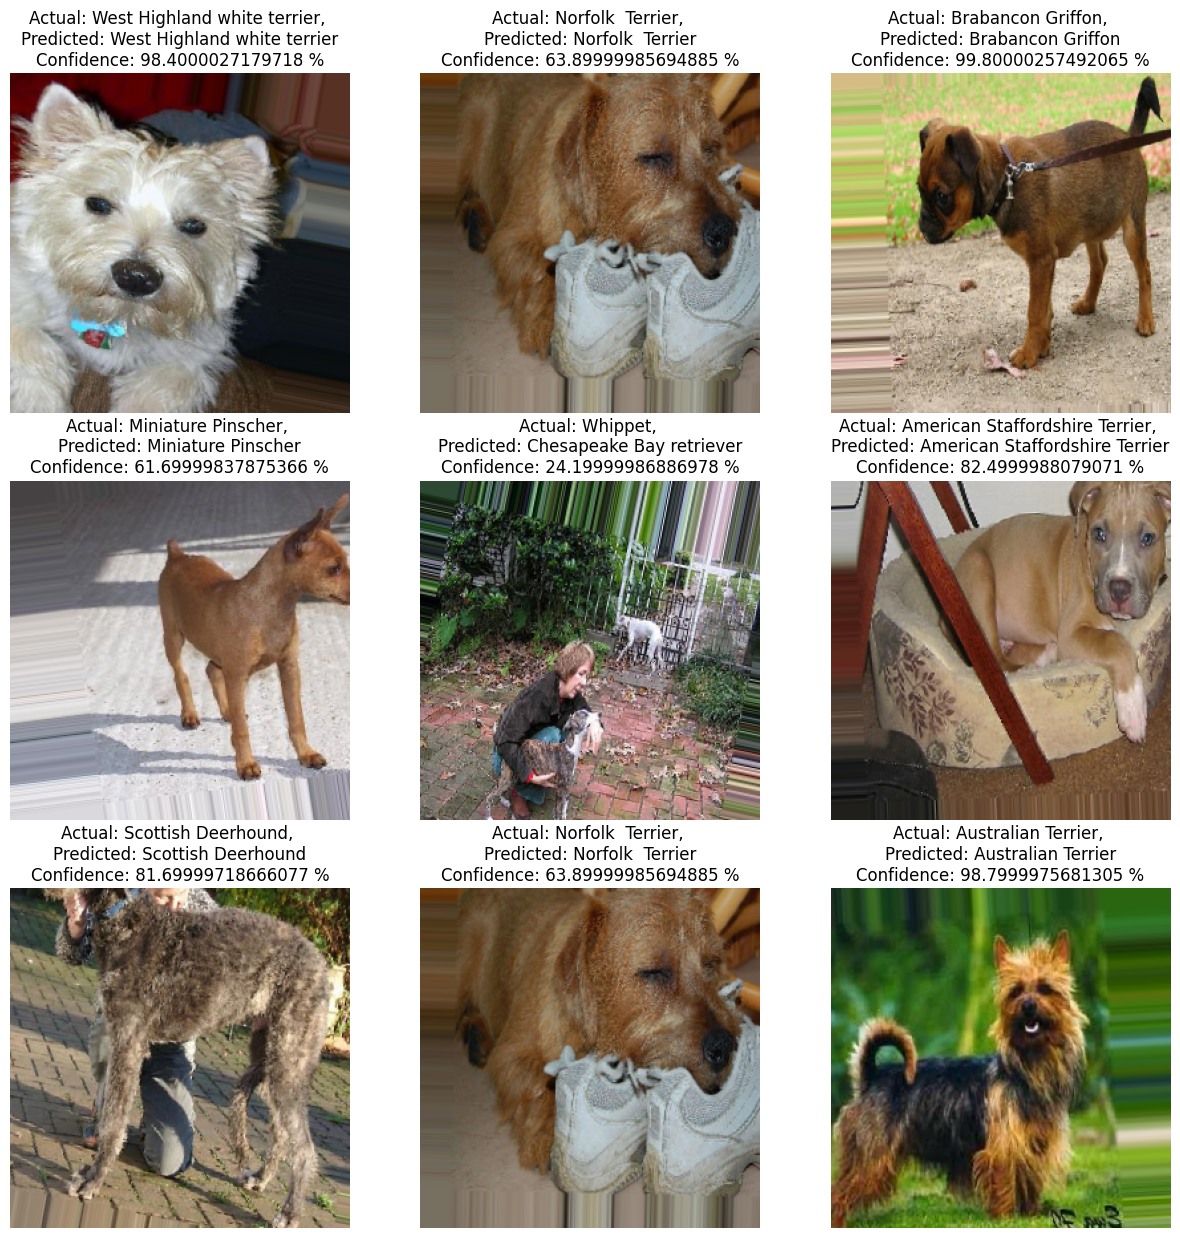

In [84]:
# Plot the first 9 images in the validation set
images_val, labels_val = next(validation_generator)
labels_predict = model.predict(images_val)
# Create a plot with 3x3 subplots
plt.figure(figsize=(15, 15))
for i in range(9):
    # Add subplots
    plt.subplot(3, 3, i + 1)
    # Generate a random number
    random_int = np.random.randint(0, len(images_val))
    # Get the predicted and actual label
    predicted_label = class_names[np.argmax(labels_predict[random_int])]
    actual_label = class_names[np.argmax(labels_val[random_int])]
    # Get the confidence of the model
    confidence = 100* round(labels_predict[random_int][np.argmax(labels_predict[random_int])], 3)
    # Plot the image
    plt.imshow(images_val[random_int])
    plt.title(f"Actual: {actual_label}, \nPredicted: {predicted_label}\nConfidence: {confidence} %")
    plt.axis("off")

In [49]:
# Save the model
model_version = "SGD-0.01-0.99-20epochs"
model.save(f"./models/{model_version}.keras")